In [13]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
import pygame
from algorithms.rl import RL
from examples.test_env import TestEnv
from algorithms.planner import Planner
import itertools
import os
import pickle
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings

# grid search
from examples.grid_search import GridSearch

In [2]:
# -*- coding: utf-8 -*-
"""
Author: John Mansfield
"""
class Blackjack:
    def __init__(self):
        self._env = gym.make('Blackjack-v1', render_mode=None)
        # Explanation of convert_state_obs lambda:
        # def function(state, done):
        # 	if done:
		#         return -1
        #     else:
        #         if state[2]:
        #             int(f"{state[0]+6}{(state[1]-2)%10}")
        #         else:
        #             int(f"{state[0]-4}{(state[1]-2)%10}")
        self._convert_state_obs = lambda state, done: (
            -1 if done else int(f"{state[0] + 6}{(state[1] - 2) % 10}") if state[2] else int(
                f"{state[0] - 4}{(state[1] - 2) % 10}"))
        
        # Transitions and rewards matrix from: https://github.com/rhalbersma/gym-blackjack-v1
        # current_dir = os.path.dirname(__file__)
        file_name = 'blackjack-envP'
        f = os.path.join(file_name)
        try:
            self._P = pickle.load(open(f, "rb"))
        except IOError:
            print("Pickle load failed.  Check path", f)
        self._n_actions = self.env.action_space.n
        self._n_states = len(self._P)

    @property
    def n_actions(self):
        return self._n_actions

    @n_actions.setter
    def n_actions(self, n_actions):
        self._n_actions = n_actions

    @property
    def n_states(self):
        return self._n_states

    @n_states.setter
    def n_states(self, n_states):
        self._n_states = n_states

    @property
    def P(self):
        return self._P

    @P.setter
    def P(self, P):
        self._P = P

    @property
    def env(self):
        return self._env

    @env.setter
    def env(self, env):
        self._env = env

    @property
    def convert_state_obs(self):
        return self._convert_state_obs

    @convert_state_obs.setter
    def convert_state_obs(self, convert_state_obs):
        self._convert_state_obs = convert_state_obs


if __name__ == "__main__":
    blackjack = Blackjack()

    # VI/PI
    # V, V_track, pi = Planner(blackjack.P).value_iteration()
    # V, V_track, pi = Planner(blackjack.P).policy_iteration()

    # Q-learning
    # Q, V, pi, Q_track, pi_track = RL(blackjack.env).q_learning(blackjack.n_states, blackjack.n_actions, blackjack.convert_state_obs)

    # test_scores = TestEnv.test_env(env=blackjack.env, render=True, pi=pi, user_input=False,
                                #    convert_state_obs=blackjack.convert_state_obs)

In [51]:
class Plots:
    @staticmethod
    def grid_world_policy_plot(data, label):
        if not math.modf(math.sqrt(len(data)))[0] == 0.0:
            warnings.warn("Grid map expected.  Check data length")
        else:
            grid = int(math.sqrt(np.array(data).shape[0]))
            data = np.around(np.array(data).reshape((grid, grid)), 2)
            df = pd.DataFrame(data=data)
            my_colors = ((0.0, 0.0, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
            cmap = LinearSegmentedColormap.from_list('Custom', my_colors, len(my_colors))
            ax = sns.heatmap(df, cmap=cmap, linewidths=1.0)
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks([.4, 1.1, 1.9, 2.6])
            colorbar.set_ticklabels(['Left', 'Down', 'Right', 'Up'])
            plt.title(label)
            plt.show()

    @staticmethod
    def grid_values_heat_map(data, label, ax=None):
        if not math.modf(math.sqrt(len(data)))[0] == 0.0:
            warnings.warn("Grid map expected.  Check data length")
        else:
            grid = int(math.sqrt(np.array(data).shape[0]))
            data = np.around(np.array(data).reshape((grid, grid)), 2)
            df = pd.DataFrame(data=data)
            sns.heatmap(df, annot=True, ax=ax).set_title(label)
            plt.show()

    @staticmethod
    def v_iters_plot(data, label):
        df = pd.DataFrame(data=data)
        df.columns = [label]
        sns.set_theme(style="whitegrid")
        title = label + " per Iterations"
        ax = sns.lineplot(x=df.index, y=label, data=df)
        ax.set_title(title)
        ax.set(xlabel='Episode')
        plt.show()

## Value Iteration

runtime = 0.03 seconds


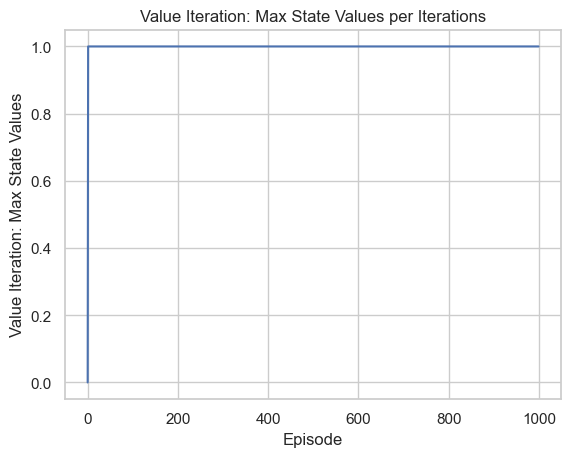

In [61]:
V, V_track, pi, conv_track = Planner(blackjack.P).value_iteration(gamma=0.5)

max_value_per_iter = np.amax(V_track, axis=1)

Plots.v_iters_plot(max_value_per_iter, "Value Iteration: Max State Values")

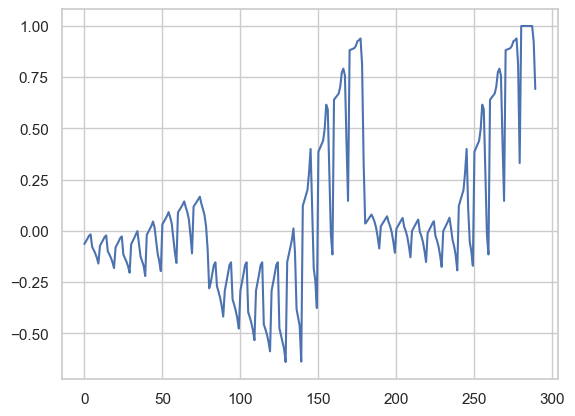

In [62]:
plt.plot(V_track.mean(axis=0))

## Policy Iteration

runtime = 0.56 seconds


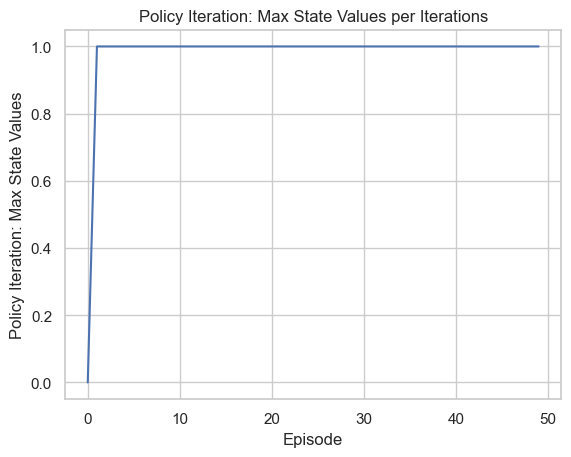

In [59]:
V, V_track, pi, conv_track = Planner(blackjack.P).policy_iteration(gamma=0.5)
max_value_per_iter = np.amax(V_track, axis=1)
Plots.v_iters_plot(max_value_per_iter, "Policy Iteration: Max State Values")

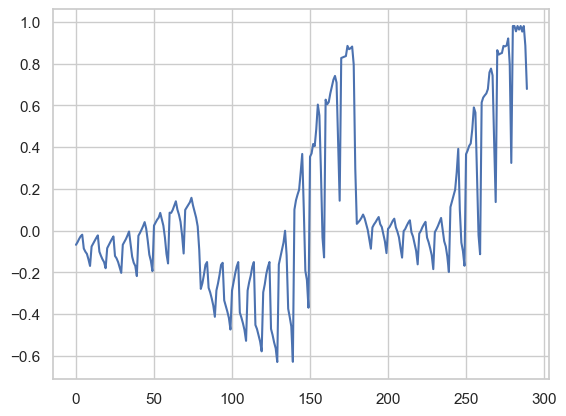

In [60]:
plt.plot(V_track.mean(axis=0))

## Q-Learning

runtime = 2.11 seconds


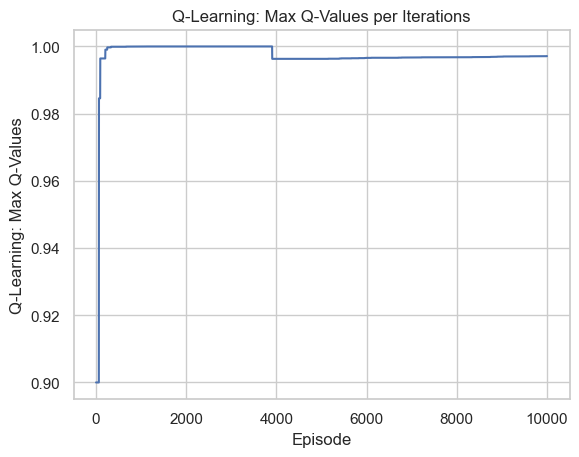

In [48]:
Q, V, pi, Q_track, pi_track = RL(blackjack.env).\
    q_learning(blackjack.n_states, blackjack.n_actions,
                blackjack.convert_state_obs, init_alpha=0.9, gamma=0.5)

max_q_value_per_iter = np.amax(np.amax(Q_track, axis=2), axis=1)

Plots.v_iters_plot(max_q_value_per_iter, "Q-Learning: Max Q-Values")

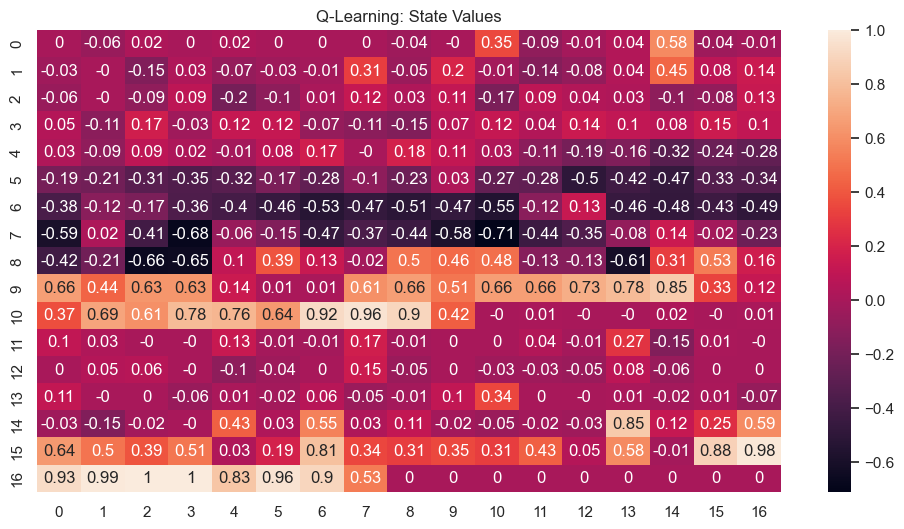

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
Plots.grid_values_heat_map(V[:-1], "Q-Learning: State Values", ax=ax)

In [29]:
V[:-1].shape

(289,)

In [23]:
math.modf(math.sqrt(len(V)))

(0.029386365926402647, 17.0)

In [80]:
Q.shape

(290, 2)

In [29]:
pi_track[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [84]:
pi_track[-1]

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [38]:
Q_track[-1].shape

(290, 2)

In [76]:
sum(Q[:,0] < Q[:,1])/ Q.shape[0]

0.5344827586206896

In [65]:
test_scores = TestEnv.test_env(env=blackjack.env, render=True, pi=pi, user_input=False,
                                convert_state_obs=blackjack.convert_state_obs)

In [86]:
test_scores

array([ 1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.])